This notebook creates and evaluates a Vector Error Correction Model. VECMs are used for non-stationary series that are cointegrated. Cointegration terms are used for including the long term relationships between non-stationary series, while the autoregressive terms capture short term relationships between the stationary remains. 

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col in cols_to_keep for new_col in new_col_names}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def weight_df(df, factor, col_factor = None):
    '''
    Weights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df * factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df * col_factor
        
    return df

def unweight_df(df, factor, col_factor):
    '''
    Unweights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df / factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df / col_factor
        
    return df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", ["Target"], "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

# apply weighting factors
factor = 100000
#standard_train_df = weight_df(standard_train_df, factor, asset_details_df.loc[:, "Weight"])
#standard_test_df = weight_df(standard_test_df, factor, None)

In [5]:
del df
gc.collect()

62

In [6]:
standard_train_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1555079640,-0.001787,-0.001882,-0.003690,-0.002951,0.006126,-0.002293,-0.001438,-0.000829,0.027632,0.002480,-0.019710,0.011912,-0.001524,-0.002559
1555079700,-0.001602,-0.000731,-0.001639,-0.002924,0.007576,-0.001225,-0.001777,0.001051,0.000000,0.003282,-0.019708,0.015584,-0.001226,-0.004204
1555079760,-0.000504,-0.001341,-0.002862,-0.003826,0.008655,-0.002608,-0.001946,-0.007041,0.026926,0.001506,-0.019706,0.014726,-0.002385,0.000026
1555079820,0.000566,-0.001508,-0.000222,-0.002333,0.009373,-0.007047,-0.001211,-0.000373,0.002067,0.000960,-0.019704,0.017296,-0.003115,-0.000975
1555079880,0.000000,-0.001657,-0.005420,-0.002824,0.009369,-0.003066,-0.001697,-0.000014,0.027723,0.000273,-0.019702,0.017488,-0.002968,-0.004186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,0.003837,-0.001987,0.001144,0.010975,-0.001471,-0.003792,0.000044,0.000378,0.009319,-0.001514,0.002873,-0.013900,0.001576,-0.000036
1624405200,0.005019,-0.002226,0.003616,0.010209,-0.002754,-0.002935,0.000567,-0.000435,0.009596,0.001226,0.005023,-0.012979,0.002292,-0.000741
1624405260,0.005909,-0.001798,0.001411,0.007625,-0.001629,-0.001701,0.001436,-0.001410,0.014052,0.001162,0.005137,-0.012925,0.003187,0.000537


In [7]:
standard_test_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1624405440,0.007666,-0.001197,0.005524,0.005235,-0.004115,-0.002951,0.002168,-0.002057,0.010136,0.000865,0.004384,-0.009090,0.001459,0.002707
1624405500,0.013220,-0.001430,0.007835,0.002967,-0.003292,-0.003119,0.001220,0.004599,0.008768,-0.002387,0.011461,-0.007924,0.002208,0.001617
1624405560,0.003928,-0.001494,0.005463,0.003012,0.000253,-0.001243,-0.001406,0.001828,-0.001801,-0.002253,0.003572,-0.006417,0.003931,0.001282
1624405620,0.002770,-0.001203,0.003554,0.002526,-0.001437,0.000759,-0.000607,-0.000611,-0.006199,0.001865,0.000289,-0.005295,0.000273,0.001187
1624405680,-0.003693,-0.000965,0.003438,0.000898,-0.000081,0.001166,0.001265,-0.003541,-0.009373,0.002602,-0.005821,-0.006012,-0.000477,0.001080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,0.002325,0.002084,0.002919,-0.003660,-0.001142,0.000941,-0.001309,0.000468,0.000664,0.002442,0.001008,-0.001876,-0.000743,0.000199
1632181260,0.000995,0.003246,-0.001943,-0.000785,-0.001968,0.000416,-0.000736,-0.000676,-0.002656,0.000665,-0.001030,-0.004123,-0.000860,-0.003477
1632181320,0.001499,0.003108,-0.000911,-0.001108,-0.000885,-0.000383,-0.000491,-0.001177,-0.003244,-0.000453,0.000006,-0.003768,-0.001822,-0.002437


In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Prepare VECM Model

First, the provided Targets will be tested for stationarity with the ADF test.

In [9]:
print("P-Values:")

# test on subset of data
n = 4
for asset in [1, 6]:
    
    print(adfuller(standard_train_df.loc[:, "Target_" + str(asset)].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()

P-Values:
0.0
0.0


Shown above, both provided targets are highly stationary as the competition providers already applied a logarithm and first difference.

The original transformations applied to the data by the competition authors will be undone to recover the original Targets.

In [10]:
np.exp(standard_df.loc[:, standard_df.columns != "timestamp"].cumsum())

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
0,9.982142e-01,0.998119,0.996317,9.970534e-01,1.006145e+00,9.977093e-01,0.998563,9.991710e-01,1.028018e+00,1.002483e+00,9.804826e-01,1.011983e+00,9.984774e-01,0.997444
1,9.966161e-01,0.997390,0.994685,9.941428e-01,1.013796e+00,9.964879e-01,0.996790,1.000222e+00,1.028018e+00,1.005779e+00,9.613482e-01,1.027878e+00,9.972538e-01,0.993260
2,9.961140e-01,0.996053,0.991843,9.903466e-01,1.022609e+00,9.938927e-01,0.994852,9.932039e-01,1.056074e+00,1.007295e+00,9.425893e-01,1.043127e+00,9.948781e-01,0.993285
3,9.966778e-01,0.994553,0.991623,9.880387e-01,1.032238e+00,9.869138e-01,0.993648,9.928336e-01,1.058259e+00,1.008262e+00,9.241985e-01,1.061325e+00,9.917836e-01,0.992317
4,9.966778e-01,0.992907,0.986262,9.852527e-01,1.041955e+00,9.838925e-01,0.991963,9.928199e-01,1.088008e+00,1.008537e+00,9.061685e-01,1.080049e+00,9.888444e-01,0.988173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285026,2.250265e+14,4.754993,0.000002,3.140291e+06,2.136260e+21,2.928074e-11,22230.473417,6.034601e+27,1.010833e+20,2.107967e-11,6.947679e-78,8.541571e+10,1.603148e-07,385.159036
1285027,2.252505e+14,4.770454,0.000002,3.137827e+06,2.132061e+21,2.929293e-11,22214.124584,6.030525e+27,1.008152e+20,2.109369e-11,6.940525e-78,8.506428e+10,1.601770e-07,383.822298
1285028,2.255884e+14,4.785306,0.000002,3.134351e+06,2.130175e+21,2.928172e-11,22203.216523,6.023429e+27,1.004886e+20,2.108414e-11,6.940565e-78,8.474440e+10,1.598855e-07,382.887913
1285029,2.279938e+14,4.798581,0.000002,3.130694e+06,2.132475e+21,2.920182e-11,22190.745178,6.007714e+27,1.011283e+20,2.107780e-11,7.002895e-78,8.495608e+10,1.596714e-07,384.746914


In [11]:
standard_train_df = np.exp(standard_train_df.cumsum())
standard_test_df = np.exp(standard_test_df.cumsum())

standard_train_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1555079640,9.982142e-01,0.998119,0.996317,0.997053,1.006145e+00,9.977093e-01,0.998563,9.991710e-01,1.028018e+00,1.002483e+00,9.804826e-01,1.011983e+00,0.998477,0.997444
1555079700,9.966161e-01,0.997390,0.994685,0.994143,1.013796e+00,9.964879e-01,0.996790,1.000222e+00,1.028018e+00,1.005779e+00,9.613482e-01,1.027878e+00,0.997254,0.993260
1555079760,9.961140e-01,0.996053,0.991843,0.990347,1.022609e+00,9.938927e-01,0.994852,9.932039e-01,1.056074e+00,1.007295e+00,9.425893e-01,1.043127e+00,0.994878,0.993285
1555079820,9.966778e-01,0.994553,0.991623,0.988039,1.032238e+00,9.869138e-01,0.993648,9.928336e-01,1.058259e+00,1.008262e+00,9.241985e-01,1.061325e+00,0.991784,0.992317
1555079880,9.966778e-01,0.992907,0.986262,0.985253,1.041955e+00,9.838925e-01,0.991963,9.928199e-01,1.088008e+00,1.008537e+00,9.061685e-01,1.080049e+00,0.988844,0.988173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,1.420733e+14,21.459048,0.000010,63775.930276,2.624537e+23,1.066043e-11,9985.582915,1.441866e+28,8.241552e+12,8.525711e-11,3.725022e-78,8.421445e+11,0.000001,7.645753
1624405200,1.427881e+14,21.411325,0.000010,64430.350233,2.617319e+23,1.062919e-11,9991.251007,1.441240e+28,8.321017e+12,8.536169e-11,3.743779e-78,8.312852e+11,0.000001,7.640094
1624405260,1.436343e+14,21.372859,0.000010,64923.485079,2.613059e+23,1.061112e-11,10005.610885,1.439209e+28,8.438767e+12,8.546093e-11,3.763060e-78,8.206100e+11,0.000001,7.644194


In [12]:
print("P-Values:")

# test on subset of data
n = 4
for asset in [1, 6]:
    
    print(adfuller(standard_train_df.loc[:, "Target_" + str(asset)].iloc[::n], 
                   regression = "nc")[1])
    
    gc.collect()

P-Values:
2.3804320173665247e-16
4.019125524466508e-17


The non-stationary series can also be visualized.

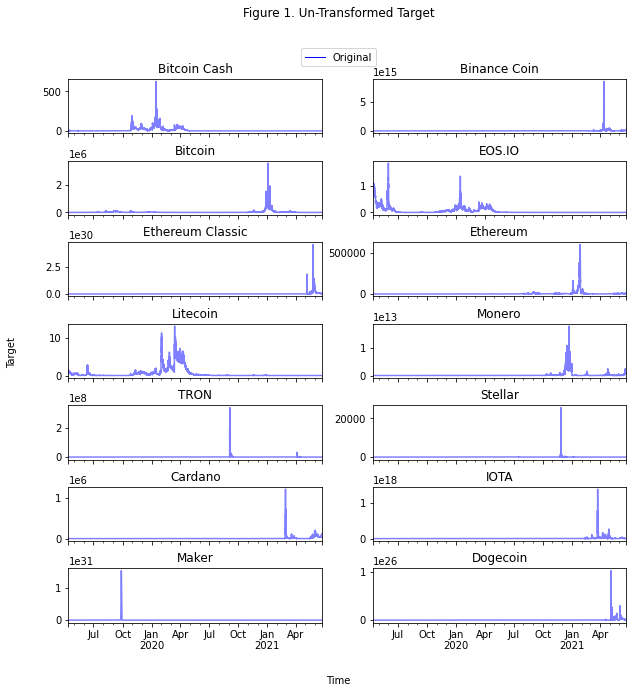

In [13]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, temp_df.columns != "timestamp"] = np.exp(temp_df.loc[:, temp_df.columns != "timestamp"].cumsum())
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])

fig.suptitle("Figure 1. Un-Transformed Target")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("ns.png")    
plt.show()

Shown above, there are clear non-stationary periods for each of the coins. However, these are very brief, and according to the ADF test each series in its entirety is still stationary. This makes the use of VECM not appropriate as cointegration is only a meaningful trait for non-stationary series. 